In [1]:
import torch
import numpy as np

import sys
sys.path.append("..")
from src.datamodules.co3d.dataset.dataloader_zoo import dataloader_zoo
from src.datamodules.co3d.dataset.dataset_zoo import dataset_zoo
from src.utils.rendering import *
from src.utils.utils import *

In [2]:
from src.utils.proj_ray_distance import *

In [3]:
matcher = init_superglue(0)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [4]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0      # 0 또는 1

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=102
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.j

In [5]:
batch_size = 5
batch_num_per_seq = 10

dataloaders = dataloader_zoo(
        datasets,
        batch_size=batch_size,
        dataset_name=f"co3d_multisequence",
        images_per_seq_options=[batch_size * batch_num_per_seq],
    )

train_loader = dataloaders["train"]

In [ ]:
N_src = 3
for frame in train_loader:
    target, srcs = data_to_frame(frame, N_src)
    tgt_cam = target["camera"].to("cuda")
    src_cams = srcs["camera"].to("cuda")
    src_cams_noise = srcs["noise_camera"].to("cuda")
    
    pair_idxs = []
    for i in range(0, N_src):
        for j in range(i+1, N_src):
            pair_idxs.append((i, j))

    total_proj_dist_loss = 0
    for pair_idx in pair_idxs:
        img1 = srcs["rgb"][pair_idx[0]].permute(1, 2, 0)
        img2 = srcs["rgb"][pair_idx[1]].permute(1, 2, 0)
        
        result = runSuperGlueSinglePair(matcher, img1, img2, 0)
        result = preprocess_match(result)
        
        if result[0] == None: 
            print("\nPass\n")
            continue
        
        pair_rays = get_pair_rays(pair_idx, src_cams, 800, 800, result)
        loss = proj_ray_dist_loss_single(result[0], result[1], src_cams, pair_idx, pair_rays, "train", 800, 800, proj_ray_dist_threshold=800*800)
        
        pair_rays_noise = get_pair_rays(pair_idx, src_cams, 800, 800, result)
        loss_noise = proj_ray_dist_loss_single(result[0], result[1], src_cams_noise, pair_idx, pair_rays_noise, "train", 800, 800, proj_ray_dist_threshold=800*800)
        
        total_proj_dist_loss += loss[0]
        # print(loss[0], loss[1])
        print("GT camera : ", loss[0])
        print("Noisy camera : ", loss_noise[0], '\n')
        
    # print(total_proj_dist_loss)

In [6]:
train_frame = next(iter(train_loader))
target, srcs = data_to_frame(train_frame, 3)

tgt_cam = target["camera"].to("cuda")
#src_cams = srcs["camera"].to("cuda")
src_cams = srcs["noise_camera"].to("cuda")
# ndc coord --> screen coord
ndc2screen = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(src_cams, 
                                                                    image_size=(800, 800), with_xyflip=True)

In [12]:
src_cams_orig = srcs["camera"].to("cuda")
src_cams = srcs["noise_camera"].to("cuda")

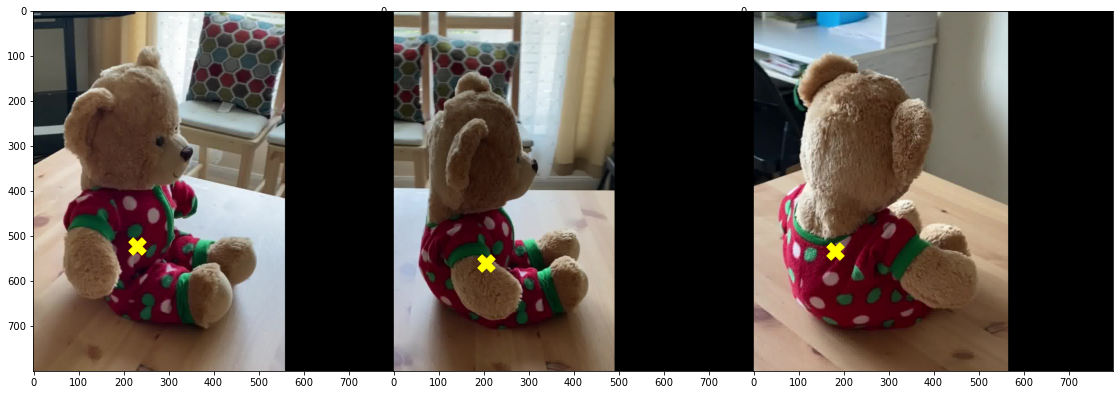

In [8]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.imshow(srcs["rgb"][i].permute(1, 2, 0))
    
    principal_ndc = src_cams.principal_point[i]
    principal_with_z = torch.ones((1, 3), device=principal_ndc.device)
    principal_with_z[..., :2] = principal_ndc
    principal_screen = ndc2screen.transform_points(principal_with_z)[i]
    plt.scatter(principal_screen[0][0].item(), principal_screen[0][1].item(), marker='X', c='yellow', s=300)
    

In [48]:
pair_idxs = (0, 2)

img1 = srcs["rgb"][pair_idxs[0]].permute(1, 2, 0)
img2 = srcs["rgb"][pair_idxs[1]].permute(1, 2, 0)

In [14]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


def draw_camera_test(fig, cam_c2w, camera_center, principal, image_bound_rays, c, color, face_color, marker, s, draw_corner=True):
    # translation
    cam_c2w = cam_c2w.detach().cpu().numpy()
    T = cam_c2w[3, :3]
                
    # principal
    x, y, z = principal[0].detach().cpu().numpy()
    fig.scatter3D(x, y, z, c=c, marker='*', s=s)
    
    # camera center
    x, y, z = camera_center.detach().cpu().numpy()
    fig.scatter3D(x, y, z, c=c, marker=marker, s=s)

    for _, ray_d in enumerate(image_bound_rays):
        xs = [x, ray_d[0].item()]
        ys = [y, ray_d[1].item()]
        zs = [z, ray_d[2].item()]

        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                            lw=1., arrowstyle="-", color=color)
        fig.add_artist(a)
    
    # 카메라의 +x, +y, +z축
    xx, xy, xz = (cam_c2w[0, :3]*2)
    yx, yy, yz = (cam_c2w[1, :3]*2)
    zx, zy, zz = (cam_c2w[2, :3]*2)

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="r")
    fig.add_artist(a)
    fig.scatter3D(xs[1], ys[1], zs[1])

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="g")
    fig.add_artist(a)
    fig.scatter3D(xs[1], ys[1], zs[1])

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="b")
    fig.add_artist(a)
    fig.scatter3D(xs[1], ys[1], zs[1])

    rays = image_bound_rays.detach().cpu().numpy()
    left_top = rays[0]
    right_top = rays[1]
    left_bottom = rays[2]
    right_bottom = rays[3]

    verts = [left_top, right_bottom, right_top, left_bottom, left_top, right_bottom]
    fig.add_collection3d(Poly3DCollection(verts, facecolors=face_color, alpha=.30))
    
    if draw_corner:
        # left-top (= image의 (0,0))
        fig.scatter3D(left_top[0], left_top[1], left_top[2], c='red', s=5)
        # right-bottom (= image의 (H-1,W-1))
        fig.scatter3D(right_bottom[0], right_bottom[1], right_bottom[2], c='blue', s=5)
        fig.scatter3D(right_top[0], right_top[1], right_top[2], c='black', s=5)
        fig.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='black', s=5)
    

def get_noise_camera_figure_test(orig_cams, noise_cams, elev=30, azim=120):
    # orig_cams : GT src views
    # noise_cams : [5 * src views]
    
    # left-top, right-top, left-bottom, right-bottom
    ndc_bound_ray = torch.tensor([[1., 1., 1.], [-1., 1., 1.], [1., -1., 1.], [-1., -1., 1.]], device=orig_cams.device)
    
    gt_K_inv = orig_cams.get_projection_transform().inverse()       # (N_src, 4, 4)
    gt_c2ws = orig_cams.get_world_to_view_transform().inverse()      # (N_src, 4, 4)
    gt_c2w_mats = gt_c2ws.get_matrix()
    
    gt_cam_bound_rays = gt_K_inv.transform_points(ndc_bound_ray)
    gt_world_bound_rays = gt_c2ws.transform_points(gt_cam_bound_rays)

    gt_principals = orig_cams.principal_point
    gt_principals_ = torch.ones_like(gt_principals[:, 0], device=orig_cams.device)[:, None]
    gt_principals = torch.cat((gt_principals, gt_principals_), dim=-1)

    if noise_cams == None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.set_xlabel("X_world")
        ax.set_ylabel("Y_world")
        ax.set_zlabel("Z_world")
        
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)
        ax.set_zlim(-6, 6)
        ax.view_init(elev=elev, azim=azim)
        for cam_idx in range(0, gt_c2w_mats.shape[0]):
            # if cam_idx == 1:
                gt_c2w_mat = gt_c2w_mats[[cam_idx]]   # (1, 4, 4)
                gt_bound_ray = gt_world_bound_rays[[cam_idx]]     # (1, 4, 3)
                
                camera_center = orig_cams.get_camera_center()[cam_idx]
                gt_cam_principal = gt_K_inv[cam_idx].transform_points(gt_principals[[cam_idx]])

                gt_world_principal = gt_c2ws[cam_idx].transform_points(gt_cam_principal)
                for step, (c2w, bound_ray) in enumerate(zip(gt_c2w_mat, gt_bound_ray)):
                    if step == 0:       # gt
                        line_color = "black"
                        c = 'black'
                        face_color = "red"
                        marker = 'd'
                        s = 50
                    # 인자로 받은 figure에 카메라 하나(c2w, bound_ray)를 그린다.
                    draw_camera_test(ax, c2w, camera_center, gt_world_principal, bound_ray, c, line_color, face_color, marker, s, draw_corner=False)
                
        return fig
        
    noise_c2w_mats = []
    noise_world_bound_rays = []
    for i, noise_cam in enumerate(noise_cams):
        K_inv = noise_cam.get_projection_transform().inverse()       # (N_src, 4, 4)
        c2w = noise_cam.get_world_to_view_transform().inverse()      # (N_src, 4, 4)
        noise_c2w_mats.append(c2w.get_matrix())

        cam_bound_ray = K_inv.transform_points(ndc_bound_ray)
        world_bound_rays = c2w.transform_points(cam_bound_ray)
        noise_world_bound_rays.append(world_bound_rays)
        if i == len(noise_cams) - 1:
            break
    noise_c2w_mats = torch.stack(noise_c2w_mats, dim=1)                       # (N_src, optim_step, 4, 4)
    noise_world_bound_rays = torch.stack(noise_world_bound_rays, dim=1)     # (N_src, optim_step, 4, 3)
    figs = []   
    for cam_idx in range(0, gt_c2w_mats.shape[0]):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.set_xlabel("X_world")
        ax.set_ylabel("Y_world")
        ax.set_zlabel("Z_world")
        ax.view_init(elev=elev, azim=azim)
        
        gt_c2w_mat = gt_c2w_mats[[cam_idx]]   # (1, 4, 4)
        gt_bound_ray = gt_world_bound_rays[[cam_idx]]     # (1, 4, 3)
        noise_c2w_mat = noise_c2w_mats[cam_idx]      # (optim_step, 4, 4)
        noise_bound_ray = noise_world_bound_rays[cam_idx]   # (optim_step, 4, 3)

        c2w_mats = torch.cat((gt_c2w_mat, noise_c2w_mat), dim=0)        # (1+optim_step, 4, 4)
        bound_rays = torch.cat((gt_bound_ray, noise_bound_ray), dim=0)  # (1+optim_step, 4, 3)
        
        colors = ["lightgray", "silver", "gray", "dimgray", "black"]
        for step, (c2w, bound_ray) in enumerate(zip(c2w_mats, bound_rays)):
            if step == 0:       # gt
                line_color = "black"
                c = 'black'
                face_color = "red"
                marker = 'd'
                s = 1
            else:
                line_color = colors[step-1]
                c = colors[step-1]
                face_color = "gray"
                marker = 'o'
                s = 30
            
            # 인자로 받은 figure에 카메라 하나(c2w, bound_ray)를 그린다.
            draw_camera_test(ax, c2w, bound_ray, c, line_color, face_color, marker, s, draw_corner=False)
            
        figs.append(fig)
            
    return figs

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2542167/3476450891.py:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


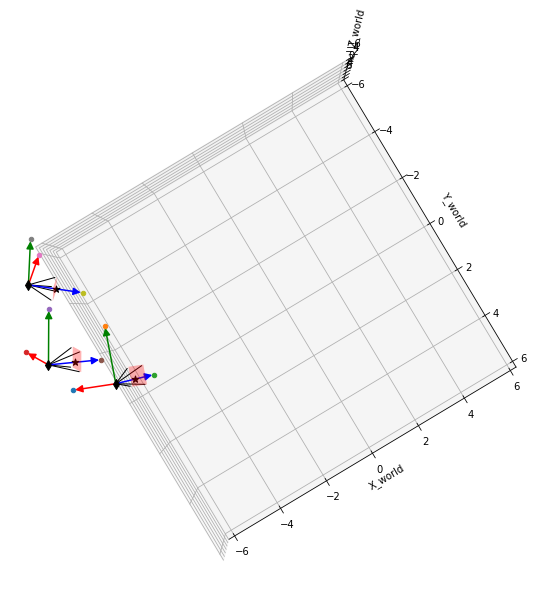

In [15]:
figure = get_noise_camera_figure_test(src_cams_orig, None, elev=-90, azim=300)

/tmp/ipykernel_1180774/3476450891.py:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


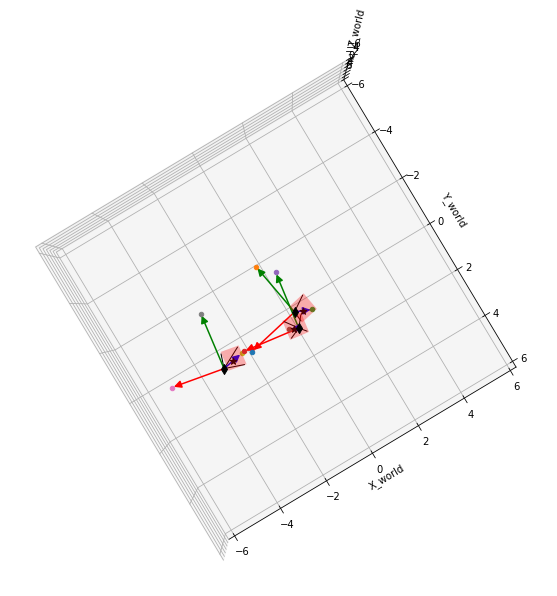

In [13]:
figure = get_noise_camera_figure_test(src_cams, None, elev=-90, azim=300)

In [49]:
result = runSuperGlueSinglePair(matcher, img1, img2, 0)

result = preprocess_match(result)
print(result.shape)

torch.Size([2, 2, 2])


tensor([144., 216.], device='cuda:0') tensor([271., 236.], device='cuda:0')


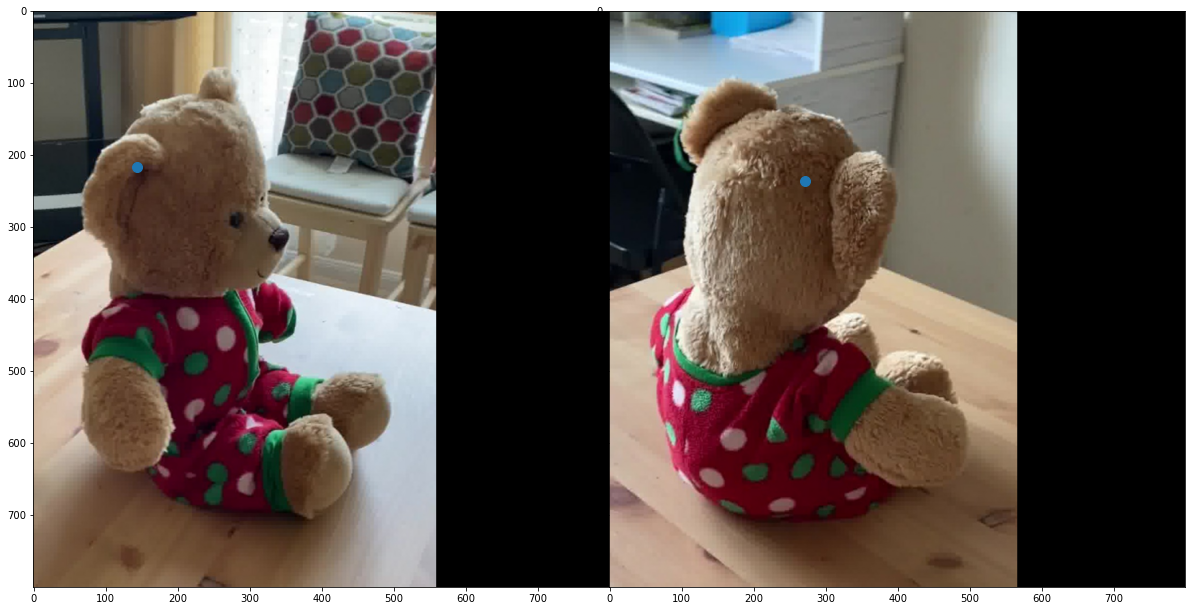

In [51]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

corr_idx = 1

plt.subplot(1, 2, 1)
plt.imshow(img1.numpy())
for x, y in result[0][corr_idx:corr_idx+1]:
    x = x.item()
    y = y.item()
    plt.scatter(x, y, s=100, cmap="yellow")
    
plt.subplot(1, 2, 2)
plt.imshow(img2.numpy())
for x, y in result[1][corr_idx:corr_idx+1]:
    x = x.item()
    y = y.item()
    plt.scatter(x, y, s=100, cmap="yellow")

keypoint_left = result[0, corr_idx]
keypoint_right = result[1, corr_idx]

print(keypoint_left, keypoint_right)

In [52]:
result_one = result[:, corr_idx:corr_idx+1, :]
print(result_one, result_one.shape)

tensor([[[144., 216.]],

        [[271., 236.]]], device='cuda:0') torch.Size([2, 1, 2])


In [16]:
def get_rotation_matrix(delta_a1, delta_a2):
    a1 = torch.tensor([1, 0, 0], dtype=torch.float32, device=delta_a1.device)
    a2 = torch.tensor([0, 1, 0], dtype=torch.float32, device=delta_a1.device)
    a1 += delta_a1
    a2 += delta_a2
    
    # rotation update
    r1 = a1 / a1.norm(p=2, dim=-1)  # L2_norm(a1) = r1
    r2 = (a2 - r1.dot(a2)*r1)       # r1과 a2를 이용하여 r1과 수직인 r2를 만듦
    if r2.norm(p=2, dim=-1) != 0.:
        r2 /= r2.norm(p=2, dim=-1)                  # L2_norm(r2) = r2
    r3 = r1.cross(r2)                           # r1와 r2를 외적하여 r3 생성
    if r3.norm(p=2, dim=-1) != 0.:
        r3 /= r3.norm(p=2, dim=-1)                  # L2_norm(r3) = r3
    
    rotation_matrix = torch.stack((r1, r2, r3), dim=0)      # row major
    
    return rotation_matrix


def get_rotation_matrix_multi(delta_a):
    a1 = delta_a[:, 0]      # (cameras, 3)
    a2 = delta_a[:, 1]      # (cameras, 3)
    
    # rotation update
    r1 = a1 / a1.norm(p=2, dim=-1)              # L2_norm(a1) = r1
    r2 = (a2 - torch.matmul(r1, a2)*r1)         # r1과 a2를 이용하여 r1과 수직인 r2를 만듦
    r2 /= r2.norm(p=2, dim=-1)                  # L2_norm(r2) = r2
    r3 = torch.cross(r1, r2, dim=-1)            # r1와 r2를 외적하여 r3 생성
    print(r3.norm(p=2, dim=-1))
    r3 /= r3.norm(p=2, dim=-1)                  # L2_norm(r3) = r3

    rotation_matrix = torch.stack((r1, r2, r3), dim=1)      # row major
    
    return rotation_matrix


def get_translation_vector(delta_t):
    t = torch.zeros(3)
    
    return t + delta_t

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1180668/3476450891.py:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


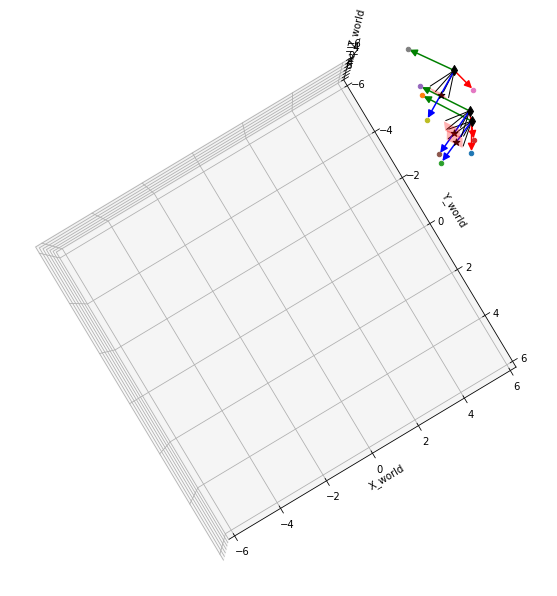

In [39]:
figure = get_noise_camera_figure_test(src_cams_orig, None, elev=-90, azim=300)

In [30]:
print(pair_idxs)
cam_idx = pair_idxs[0]

(0, 1)


In [27]:
img = srcs["rgb"][0]

W = img.shape[2]
H = img.shape[1]
print(f"Width : {W} / Height : {H}")

u, v = np.meshgrid(np.arange(W), np.arange(H))

# 이미지의 각 row들이 한 줄로 이어붙은 형태로 변환
# (H, W) --> (H*W)
u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]? 아니면 homogeneous coordinate라 1을 추가한 건지?
pixels = torch.from_numpy(pixels).to(src_cams.device)
batched_pixels = pixels.unsqueeze(0).repeat(1, 1, 1)

# bmm : batch matrix-matrix product 
# [B, N, M] tensor * [B, M, P] tensor >>> [B, N, P]
screen_px = batched_pixels.transpose(1, 2).reshape(-1, 3)
print("\n< pixels in screen >\n", screen_px.shape, '\n', screen_px[:5])

screen_bound = [screen_px[0], screen_px[W-1], screen_px[W*(H-1)], screen_px[-1]]
screen_bound = torch.stack(screen_bound)
print("< Bound in screen>\n", screen_bound)

Width : 800 / Height : 800

< pixels in screen >
 torch.Size([640000, 3]) 
 tensor([[0., 0., 1.],
        [1., 0., 1.],
        [2., 0., 1.],
        [3., 0., 1.],
        [4., 0., 1.]], device='cuda:0')
< Bound in screen>
 tensor([[  0.,   0.,   1.],
        [799.,   0.,   1.],
        [  0., 799.,   1.],
        [799., 799.,   1.]], device='cuda:0')


In [28]:
u, v = np.meshgrid(np.arange(W), np.arange(H))

# screen >>> ndc
screen2ndc_true = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(src_cams, image_size=(H, W), with_xyflip=True)
ndc_px = screen2ndc_true.transform_points(screen_px)[0]
print("\n< pixels in ndc >\n", ndc_px.shape, '\n', ndc_px[:5])

ndc_bound = [ndc_px[0], ndc_px[W-1], ndc_px[W*(H-1)], ndc_px[-1]]
ndc_bound = torch.stack(ndc_bound)

# image_bound_o_ndc = [rays_o_ndc[0], rays_o_ndc[W-1], rays_o_ndc[W*(H-1)], rays_o_ndc[-1]]
# image_bound_o_ndc = torch.stack(image_bound_o_ndc)

print("< Bound in ndc >\n", ndc_bound)


< pixels in ndc >
 torch.Size([640000, 3]) 
 tensor([[1.0000, 1.0000, 1.0000],
        [0.9975, 1.0000, 1.0000],
        [0.9950, 1.0000, 1.0000],
        [0.9925, 1.0000, 1.0000],
        [0.9900, 1.0000, 1.0000]], device='cuda:0')
< Bound in ndc >
 tensor([[ 1.0000,  1.0000,  1.0000],
        [-0.9979,  1.0000,  1.0000],
        [ 1.0000, -0.9979,  1.0000],
        [-0.9979, -0.9979,  1.0000]], device='cuda:0')


In [31]:
# K_inv만 곱해서 NDC >> Camera 좌표계로 변환한 ray
K_inv = src_cams.get_projection_transform()[cam_idx].inverse()
rays_d_cam = K_inv.transform_points(ndc_px)
# rays_o_cam = K_inv.transform_points(rays_o)
rays_o_cam = torch.zeros_like(rays_d_cam)

print(rays_d_cam.shape)
print(rays_o_cam.shape)

print("(0, 0) screen pixel in ndc : ", ndc_px[0])
print("(0, 0) pixel ray in camera : ", rays_d_cam[0])
print()
print("(W-1, 0) screen pixel in ndc : ", ndc_px[W-1])
print("(W_1, 0) pixel ray in camera : ", rays_d_cam[W-1])
print()
print("(0, H-1) screen pixel in ndc : ", ndc_px[W*(H-1)])
print("(0, H-1) pixel ray in camera : ", rays_d_cam[W*(H-1)])
print()
print("(W-1, H-1) screen pixel in ndc : ", ndc_px[-1])
print("(W-1, H-1) pixel ray in camera : ", rays_d_cam[-1])

torch.Size([640000, 3])
torch.Size([640000, 3])
(0, 0) screen pixel in ndc :  tensor([1., 1., 1.], device='cuda:0')
(0, 0) pixel ray in camera :  tensor([0.2629, 0.4716, 1.0000], device='cuda:0')

(W-1, 0) screen pixel in ndc :  tensor([-0.9979,  1.0000,  1.0000], device='cuda:0')
(W_1, 0) pixel ray in camera :  tensor([-0.4690,  0.4716,  1.0000], device='cuda:0')

(0, H-1) screen pixel in ndc :  tensor([ 1.0000, -0.9979,  1.0000], device='cuda:0')
(0, H-1) pixel ray in camera :  tensor([ 0.2629, -0.2604,  1.0000], device='cuda:0')

(W-1, H-1) screen pixel in ndc :  tensor([-0.9979, -0.9979,  1.0000], device='cuda:0')
(W-1, H-1) pixel ray in camera :  tensor([-0.4690, -0.2604,  1.0000], device='cuda:0')


In [32]:
pair_colors = ["red", "blue"]

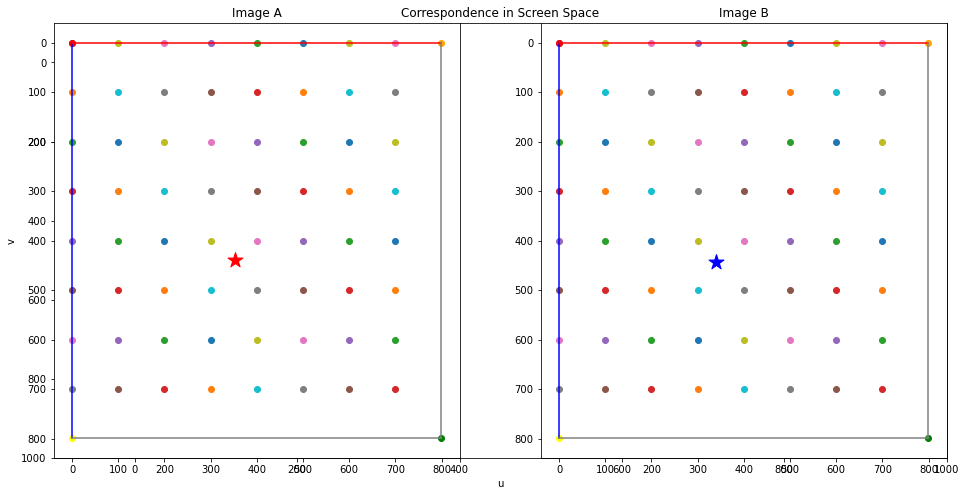

In [33]:
fig = plt.figure(figsize=(16, 8))

plt.title("Correspondence in Screen Space")
plt.xlabel("u")
plt.ylabel("v")

plt.xlim(-100, 1000)  # u축 (=x)
plt.ylim(1000, -100)  # v축 (=y)


for i, keypoint in enumerate(result_one):
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title("Image %s"%(['A', 'B'][i]))
    ax.invert_yaxis()
    # Screen 좌표계에서 정의된 각 픽셀 좌표 시각화
    xs = screen_px[:W][::100][:, 0]        # screen pixels의 width(0 ~ 799)를 100 간격으로 나눔
    ys = screen_px[::W][::100][:, 1]                  # screen pixels의 height(0 ~ 799)를 100 간격으로 나눔

    for x in xs:
        for y in ys:
            plt.scatter(x.item(), y.item(), cmap='b')


    # ndc2screen_true = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(src_cams, image_size=(800, 800), with_xyflip=True)

    # principal = torch.ones((1, 3), device=src_cams.device)
    # principal[:, :2] = src_cams.principal_point[cam_idx]
    # principal_screen = ndc2screen_true.transform_points(principal)[cam_idx]
    # print("Principal point in Screen : ", principal_screen)

    ax.scatter(keypoint[0, 0].item(), keypoint[0, 1].item(), c=pair_colors[i], marker='*', s=250)

    # screen의 left_top
    screen_bound_np = screen_bound.cpu().numpy()
    left_top = screen_bound_np[0]
    ax.scatter(left_top[0], left_top[1], c='red')
    # screen의 right_top
    right_top = screen_bound_np[1]
    ax.scatter(right_top[0], right_top[1], c='orange')
    # screen의 left_bottom
    left_bottom = screen_bound_np[2]
    ax.scatter(left_bottom[0], left_bottom[1], c='yellow')
    # screen의 right_bottom
    right_bottom = screen_bound_np[3]
    ax.scatter(right_bottom[0], right_bottom[1], c='green')

    # left
    ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), 'blue')
    # top
    ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), 'red')
    # right
    ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), 'gray')
    # bottom
    ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), 'gray')

tensor([[ 0.1200, -0.0975,  1.0000]], device='cuda:0')
tensor([[ 0.1500, -0.1100,  1.0000]], device='cuda:0')


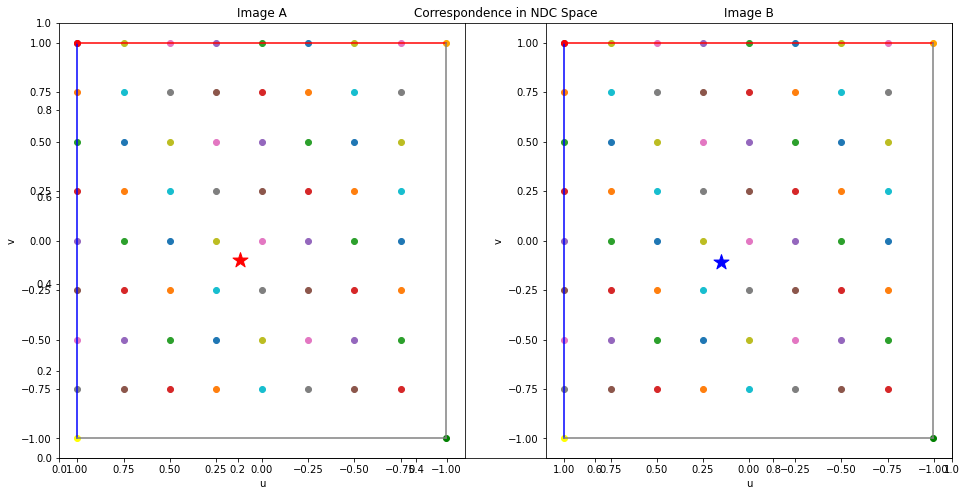

In [34]:
fig = plt.figure(figsize=(16, 8))
plt.title("Correspondence in NDC Space")

for i, keypoint in enumerate(result_one):
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title("Image %s"%(['A', 'B'][i]))
    ax.set_xlabel("u")
    ax.set_ylabel("v")

    # ax.set_xlim(-1.5, 1.5)  # u축 (=x)
    # ax.set_ylim(1.5, -1.5)  # v축 (=y)
    ax.invert_xaxis()
    # ax.invert_yaxis()

    # NDC 좌표계에서 정의된 각 픽셀 좌표 시각화
    xs = ndc_px[:W][::100][:, 0]        # ndc pixels의 width(0 ~ 799)를 100 간격으로 나눔
    ys = ndc_px[::W][::100][:, 1]                  # ndc pixels의 height(0 ~ 799)를 100 간격으로 나눔

    for x in xs:
        for y in ys:
            ax.scatter(x.item(), y.item(), cmap='b')

    # principal_ndc = torch.ones((1, 3))
    # principal_ndc[:, :2] = src_cams.principal_point[cam_idx]
    # print("Principal point in NDC : ", principal_ndc)
    z = torch.ones((1, 1), device=keypoint.device)
    keypoint_xyz = torch.cat((keypoint, z), dim=-1)
    keypoint_ndc = screen2ndc_true.transform_points(keypoint_xyz)[pair_idxs[i]]
    print(keypoint_ndc)
        
    ax.scatter(keypoint_ndc[0][0].item(), keypoint_ndc[0][1].item(), c=pair_colors[i], marker='*', s=250)

    ndc_bound_np = ndc_bound.cpu().numpy()
    # screen의 left_top
    left_top = ndc_bound_np[0]
    ax.scatter(left_top[0], left_top[1], c='red')
    # screen의 right_top
    right_top = ndc_bound_np[1]
    ax.scatter(right_top[0], right_top[1], c='orange')
    # screen의 left_bottom
    left_bottom = ndc_bound_np[2]
    ax.scatter(left_bottom[0], left_bottom[1], c='yellow')
    # screen의 right_bottom
    right_bottom = ndc_bound_np[3]
    ax.scatter(right_bottom[0], right_bottom[1], c='green')

    # left
    ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), 'blue')
    # top
    ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), 'red')
    # right
    ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), 'gray')
    # bottom
    ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), 'gray')

tensor([[ 0.1200, -0.0975,  1.0000]], device='cuda:0') tensor([[-0.0594,  0.0695,  1.0000]], device='cuda:0')
tensor([[ 0.1500, -0.1100,  1.0000]], device='cuda:0') tensor([[-3.8456e-02,  7.7263e-04,  1.0000e+00]], device='cuda:0')


/tmp/ipykernel_1176734/2563160996.py:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


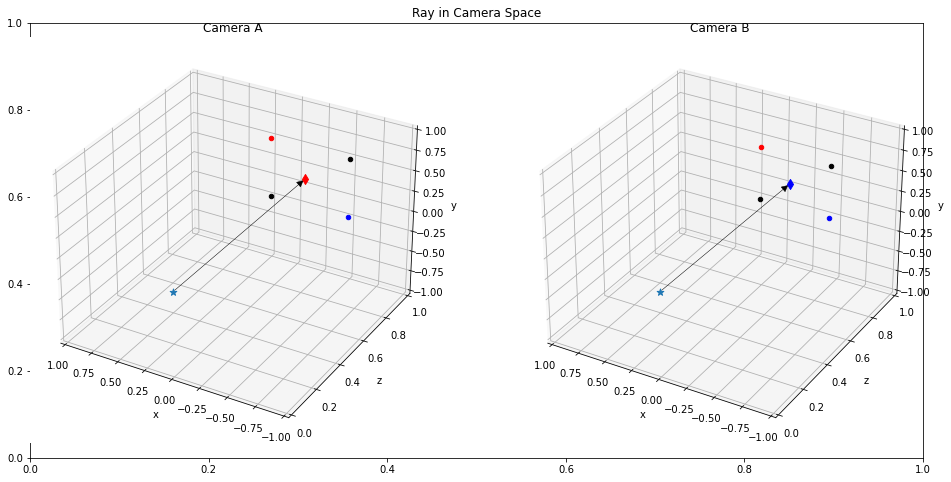

In [35]:
fig = plt.figure(figsize=(16, 8))
plt.title("Ray in Camera Space")
for i, keypoint in enumerate(result_one):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    ax.set_title("Camera %s"%(['A', 'B'][i]))

    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_zlabel("y")

    ax.set_xlim3d(1, -1)  # u축 (=x)
    ax.set_ylim3d(0, 1)     # z축 (=1)
    ax.set_zlim3d(-1, 1)  # v축 (=y)

    # # intrinsic_inv만 곱한 ray 시각화
    # for ray_o, ray_d in zip(rays_o_cam[::300], rays_d_cam[::300]):
    #     xs = [ray_o[0].item(), ray_d[0].item()]
    #     ys = [ray_o[1].item(), ray_d[1].item()]
    #     zs = [ray_o[2].item(), ray_d[2].item()]

    #     a = Arrow3D(xs, zs, ys, mutation_scale=15, 
    #                     lw=0.5, arrowstyle="-|>", color="gray")
    #     ax.add_artist(a)
    x, y, z = rays_o_cam[0].cpu().numpy()
    # x, y, z = ray_o[0].item(), ray_o[1].item(), ray_o[2].item()
    ax.scatter3D(x, z, y, cmap='Greens', marker='*', s=50)

    # principal_ = torch.ones((1, 3), device=src_cams.device)
    # principal_[..., :2] = principal_ndc[..., :2]
    # principal_cam = K_inv.transform_points(principal_)
    # print("Principal point in cam : ", principal_cam)
    z = torch.ones((1, 1), device=keypoint.device)
    keypoint_xyz = torch.cat((keypoint, z), dim=-1)
    keypoint_ndc = screen2ndc_true.transform_points(keypoint_xyz)[pair_idxs[i]]
    
    K_inv = src_cams.get_projection_transform()[i].inverse()
    keypoint_cam = K_inv.transform_points(keypoint_ndc)
    print(keypoint_ndc, keypoint_cam)
    x, y, z = keypoint_cam[0, 0].item(), keypoint_cam[0, 1].item(), keypoint_cam[0, 2].item()
    ax.scatter3D(x, z, y, c=pair_colors[i], marker='d', s=50)
    
    xs = [rays_o_cam[0, 0].item(), keypoint_cam[0, 0].item()]
    ys = [rays_o_cam[0, 1].item(), keypoint_cam[0, 1].item()]
    zs = [rays_o_cam[0, 2].item(), keypoint_cam[0, 2].item()]

    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="black")
    ax.add_artist(a)
    
    cam_bound_ray = K_inv.transform_points(ndc_bound).cpu().numpy()
    # image의 left_top
    left_top = cam_bound_ray[0]
    ax.scatter3D(left_top[0], left_top[2], left_top[1], c='red')
    # image의 right_top
    right_top = cam_bound_ray[1]
    ax.scatter3D(right_top[0], right_top[2], right_top[1], c='black')
    # image의 left_bottom
    left_bottom = cam_bound_ray[2]
    ax.scatter3D(left_bottom[0], left_bottom[2], left_bottom[1], c='black')
    # image의 right_bottom
    right_bottom = cam_bound_ray[3]
    ax.scatter3D(right_bottom[0], right_bottom[2], right_bottom[1], c='blue')



screen : tensor([[352., 439.,   1.]], device='cuda:0')
ndc : tensor([[ 0.1200, -0.0975,  1.0000]], device='cuda:0')
cam : tensor([[-0.0594,  0.0695,  1.0000]], device='cuda:0')
world : [[-3.7356932   0.17097443 -7.822011  ]]
Correspondence in Camera A
ray_o :  (-4.35515, 0.041287065, -8.599861)
ray_d :  [0.619457   0.12968737 0.77785015]
screen : tensor([[340., 444.,   1.]], device='cuda:0')
ndc : tensor([[ 0.1500, -0.1100,  1.0000]], device='cuda:0')
cam : tensor([[-3.8456e-02,  7.7263e-04,  1.0000e+00]], device='cuda:0')
world : [[ 5.134574  -0.8430534 -7.7920794]]
Correspondence in Camera B
ray_o :  (5.72209, -0.86763424, -8.601729)
ray_d :  [-0.58751583  0.02458084  0.80964994]


/tmp/ipykernel_1176734/2563160996.py:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


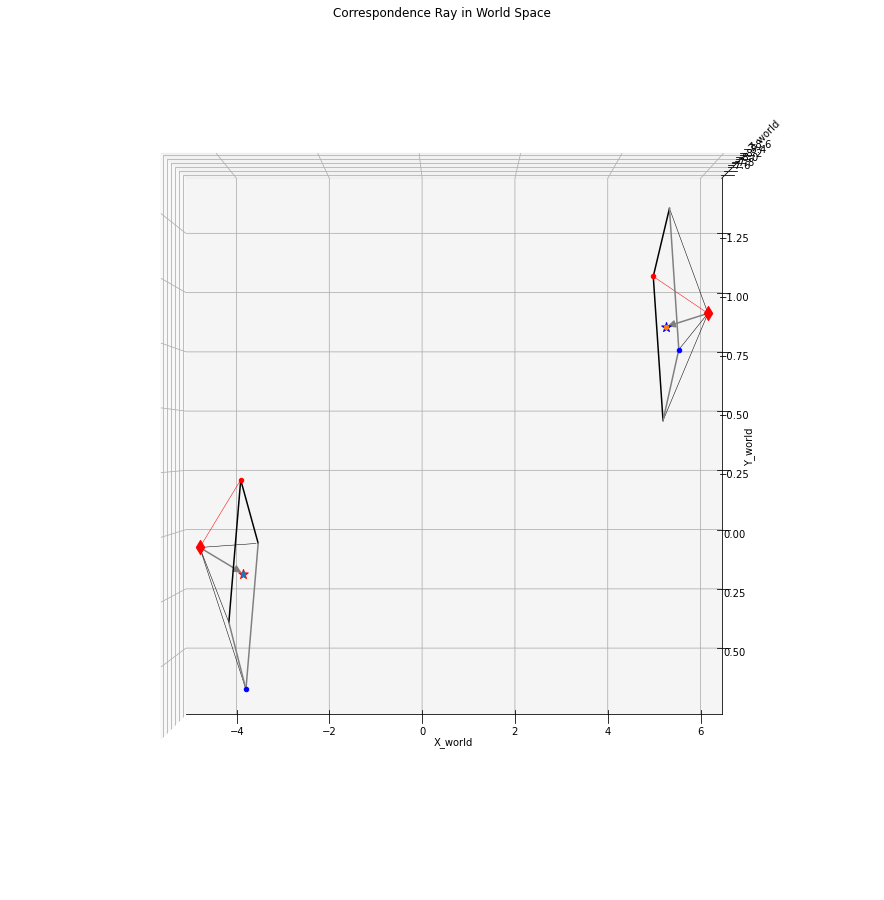

In [36]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_title("Correspondence Ray in World Space")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)
ax.view_init(elev=-90, azim=-90)

corr_ray_ds = []
corr_ray_os = []
for idx, cam_i in enumerate(pair_idxs):

    camera_centers = src_cams.get_camera_center().cpu().numpy()[cam_i]
    x, y, z = camera_centers

    ax.scatter3D(x, y, z, c='red', marker='d', s=100)

    c2w = src_cams.get_world_to_view_transform()[cam_i].inverse()
    world_bound_ray = c2w.transform_points(torch.from_numpy(cam_bound_ray).to(src_cams.device))
    # principal_world = c2w.transform_points(principal_cam)[0]

    for i, ray_d in enumerate(world_bound_ray):
        xs = [x, ray_d[0].item()]
        ys = [y, ray_d[1].item()]
        zs = [z, ray_d[2].item()]

        if i == 0:
            a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                            lw=0.5, arrowstyle="-", color="r")
        else:
            a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                            lw=0.5, arrowstyle="-", color="black")
        ax.add_artist(a)

    world_bound_ray = world_bound_ray.cpu().numpy()
    left_top = world_bound_ray[0]
    right_top = world_bound_ray[1]
    left_bottom = world_bound_ray[2]
    right_bottom = world_bound_ray[3]

    # left
    ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'black')
    # top
    ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'black')
    # right
    ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
    # bottom
    ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

    # left-top (= image의 (0,0))
    ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
    # right-bottom (= image의 (H-1,W-1))
    ax.scatter3D(right_bottom[0], right_bottom[1], right_bottom[2], c='blue')


    # # principal_world 그리기
    # ax.scatter3D(principal_world[0].item(), principal_world[1].item(), principal_world[2].item(), marker='*', s=100, c='black')
    z_depth = torch.ones((1, 1), device=src_cams.device)
    keypoint_xyz = torch.cat((result_one[idx], z_depth), dim=-1)
    print("screen :", keypoint_xyz)
    keypoint_ndc = screen2ndc_true.transform_points(keypoint_xyz)[pair_idxs[idx]]
    print("ndc :", keypoint_ndc)
    K_inv = src_cams.get_projection_transform()[cam_i].inverse()
    keypoint_cam = K_inv.transform_points(keypoint_ndc)
    print("cam :", keypoint_cam)
    keypoint_world = c2w.transform_points(keypoint_cam).cpu().numpy()
    print("world :", keypoint_world)
    ax.scatter3D(keypoint_world[0, 0], keypoint_world[0, 1], keypoint_world[0, 2], marker='*', s=100, c=pair_colors[idx])
    
    dir = (keypoint_world[0] - (x, y, z))
    corr_ray_os.append(torch.tensor([x, y, z], device=src_cams.device))
    corr_ray_ds.append(torch.tensor(dir, device=src_cams.device))
    print(f"Correspondence in Camera {['A', 'B'][idx]}")
    print("ray_o : ", (x, y, z))
    print("ray_d : ", dir)
    xs = [x, x + dir[0]]
    ys = [y, y + dir[1]]
    zs = [z, z + dir[2]]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)
    ax.scatter3D(xs[1], ys[1], zs[1])

    
    # R = c2w.get_matrix()[0, :3, :3].cpu().numpy()

    # # 카메라의 +x, +y, +z축
    # xx, xy, xz = (R[0, :]*1)
    # yx, yy, yz = (R[1, :]*1)
    # zx, zy, zz = (R[2, :]*1)

    # # 카메라의 x축 그리기
    # xs = [x, x+xx]
    # ys = [y, y+xy]
    # zs = [z, z+xz]

    # a = Arrow3D(xs, ys, zs, mutation_scale=15, 
    #             lw=1.5, arrowstyle="-|>", color="r")
    # ax.add_artist(a)
    # ax.scatter3D(xs[1], ys[1], zs[1])

    # # 카메라의 y축 그리기
    # xs = [x, x+yx]
    # ys = [y, y+yy]
    # zs = [z, z+yz]
    # a = Arrow3D(xs, ys, zs, mutation_scale=15, 
    #             lw=1.5, arrowstyle="-|>", color="g")
    # ax.add_artist(a)
    # ax.scatter3D(xs[1], ys[1], zs[1])

    # # 카메라의 z축 그리기
    # xs = [x, x+zx]
    # ys = [y, y+zy]
    # zs = [z, z+zz]
    # a = Arrow3D(xs, ys, zs, mutation_scale=15, 
    #             lw=1.5, arrowstyle="-|>", color="b")
    # ax.add_artist(a)
    # ax.scatter3D(xs[1], ys[1], zs[1])

In [65]:
print(result.shape)
print(result_one.shape)

torch.Size([2, 211, 2])
torch.Size([2, 1, 2])


In [37]:
corr_ray_os_tensor = torch.stack(corr_ray_os, dim=0).unsqueeze(1)
corr_ray_ds_tensor = torch.stack(corr_ray_ds, dim=0).unsqueeze(1)
print(corr_ray_os)
print(corr_ray_ds)
eps = 1e-10

[tensor([-4.3552,  0.0413, -8.5999], device='cuda:0'), tensor([ 5.7221, -0.8676, -8.6017], device='cuda:0')]
[tensor([0.6195, 0.1297, 0.7779], device='cuda:0'), tensor([-0.5875,  0.0246,  0.8096], device='cuda:0')]


In [38]:
corr_ray_ds_tensor = corr_ray_ds_tensor / (corr_ray_ds_tensor.norm(p=2, dim=-1) + eps).unsqueeze(-1)  # unit vector

rays_d_0, rays_d_1 = corr_ray_ds_tensor[0].unsqueeze(0), corr_ray_ds_tensor[1].unsqueeze(0)      # (1, correspondences, 3)
rays_o_0, rays_o_1 = corr_ray_os_tensor[0].unsqueeze(0), corr_ray_os_tensor[1].unsqueeze(0)      # (1, correspondences, 3)
print(rays_d_0.shape, rays_d_1.shape)
rays_d_0 = rays_d_0 / (rays_d_0.norm(p=2, dim=-1)[:, :, None] + eps)
rays_d_1 = rays_d_1 / (rays_d_1.norm(p=2, dim=-1)[:, :, None] + eps) 

r0_r1 = torch.einsum(
    "ijk, ijk -> ij", 
    rays_d_0, 
    rays_d_1
)
# 첫 번째 이미지에서의 각 특징점들로 향하는 step 거리
t0 = (
    torch.einsum(
        "ijk, ijk -> ij", 
        rays_d_0, 
        rays_o_0 - rays_o_1
    ) - r0_r1
    * torch.einsum(
        "ijk, ijk -> ij", 
        rays_d_1, 
        rays_o_0 - rays_o_1
    )
) / (r0_r1 ** 2 - 1 + eps)
# 두 번째 이미지에서의 각 특징점들로 향하는 step 거리
t1 = (
    torch.einsum(
        "ijk, ijk -> ij", 
        rays_d_1, 
        rays_o_1 - rays_o_0
    ) - r0_r1
    * torch.einsum(
        "ijk, ijk -> ij", 
        rays_d_0, 
        rays_o_1 - rays_o_0
    )
) / (r0_r1 ** 2 - 1 + eps)

# 각 이미지에서의 특징점들의 포인트 X_A, X_B
p0 = t0[:, :, None] * rays_d_0 + rays_o_0
p1 = t1[:, :, None] * rays_d_1 + rays_o_1

torch.Size([1, 1, 3]) torch.Size([1, 1, 3])


In [39]:
print(p0)
print(p1)

tensor([[[ 0.7707,  1.1144, -2.1633]]], device='cuda:0')
tensor([[[ 0.9276, -0.6670, -1.9945]]], device='cuda:0')


screen : tensor([[352., 439.,   1.]], device='cuda:0')
ndc : tensor([[ 0.1200, -0.0975,  1.0000]], device='cuda:0')
cam : tensor([[-0.0594,  0.0695,  1.0000]], device='cuda:0')
screen : [[-3.7356932   0.17097443 -7.822011  ]]
screen : tensor([[340., 444.,   1.]], device='cuda:0')
ndc : tensor([[ 0.1500, -0.1100,  1.0000]], device='cuda:0')
cam : tensor([[-3.8456e-02,  7.7263e-04,  1.0000e+00]], device='cuda:0')
screen : [[ 5.134574  -0.8430534 -7.7920794]]


/tmp/ipykernel_1176734/2563160996.py:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


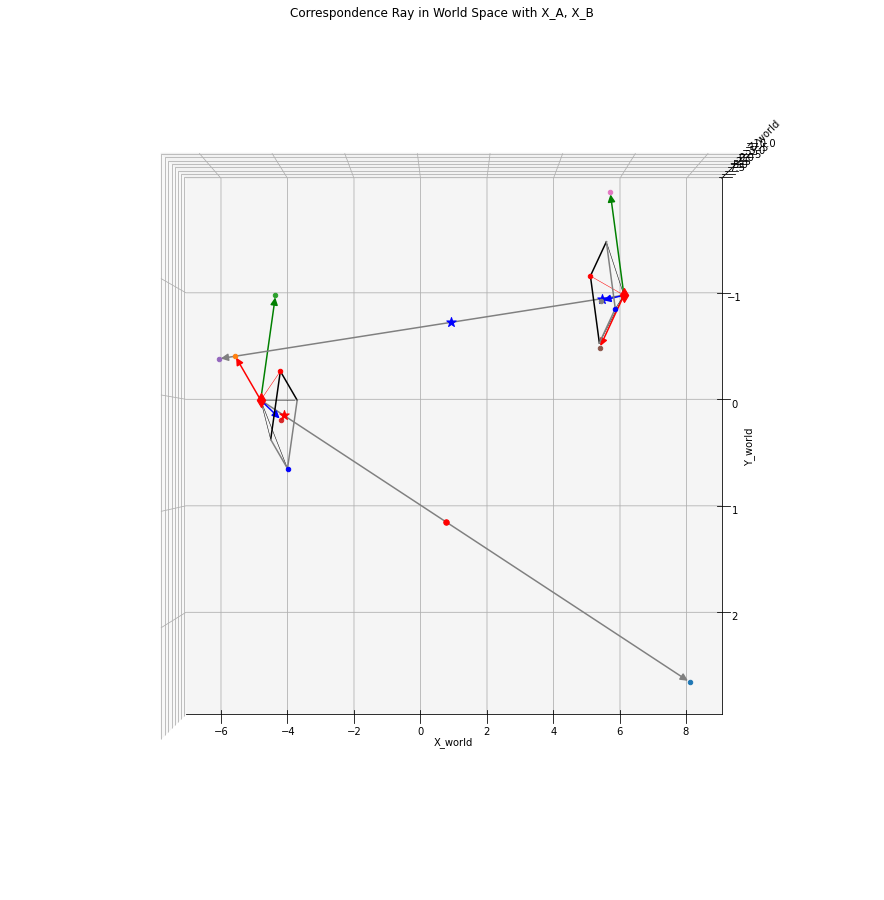

In [40]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_title("Correspondence Ray in World Space with X_A, X_B")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)
ax.view_init(elev=-90, azim=-90)

keypoint_to_pair_imgs = []
for idx, cam_i in enumerate(pair_idxs):

    camera_centers = src_cams.get_camera_center().cpu().numpy()[cam_i]
    x, y, z = camera_centers

    ax.scatter3D(x, y, z, c='red', marker='d', s=100)

    c2w = src_cams.get_world_to_view_transform()[cam_i].inverse()
    world_bound_ray = c2w.transform_points(torch.from_numpy(cam_bound_ray).to(src_cams.device))
    # principal_world = c2w.transform_points(principal_cam)[0]

    for i, ray_d in enumerate(world_bound_ray):
        xs = [x, ray_d[0].item()]
        ys = [y, ray_d[1].item()]
        zs = [z, ray_d[2].item()]

        if i == 0:
            a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                            lw=0.5, arrowstyle="-", color="r")
        else:
            a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                            lw=0.5, arrowstyle="-", color="black")
        ax.add_artist(a)

    world_bound_ray = world_bound_ray.cpu().numpy()
    left_top = world_bound_ray[0]
    right_top = world_bound_ray[1]
    left_bottom = world_bound_ray[2]
    right_bottom = world_bound_ray[3]

    # left
    ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'black')
    # top
    ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'black')
    # right
    ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
    # bottom
    ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

    # left-top (= image의 (0,0))
    ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
    # right-bottom (= image의 (H-1,W-1))
    ax.scatter3D(right_bottom[0], right_bottom[1], right_bottom[2], c='blue')


    # # principal_world 그리기
    # ax.scatter3D(principal_world[0].item(), principal_world[1].item(), principal_world[2].item(), marker='*', s=100, c='black')
    z_depth = torch.ones((1, 1), device=src_cams.device)
    keypoint_xyz = torch.cat((result_one[idx], z_depth), dim=-1)
    print("screen :", keypoint_xyz)
    keypoint_ndc = screen2ndc_true.transform_points(keypoint_xyz)[pair_idxs[idx]]
    print("ndc :", keypoint_ndc)
    K_inv = src_cams.get_projection_transform()[cam_i].inverse()
    keypoint_cam = K_inv.transform_points(keypoint_ndc)
    print("cam :", keypoint_cam)
    keypoint_world = c2w.transform_points(keypoint_cam).cpu().numpy()
    print("screen :", keypoint_world)
    ax.scatter3D(keypoint_world[0, 0], keypoint_world[0, 1], keypoint_world[0, 2], marker='*', s=100, c=pair_colors[idx])
    dir = (keypoint_world[0] - (x, y, z))*20

    xs = [x, x + dir[0]]
    ys = [y, y + dir[1]]
    zs = [z, z + dir[2]]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)
    ax.scatter3D(xs[1], ys[1], zs[1])

    R = c2w.get_matrix()[0, :3, :3].cpu().numpy()

    # 카메라의 +x, +y, +z축
    xx, xy, xz = (R[0, :]*1)
    yx, yy, yz = (R[1, :]*1)
    zx, zy, zz = (R[2, :]*1)

    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    ax.scatter3D(xs[1], ys[1], zs[1])

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="g")
    ax.add_artist(a)
    ax.scatter3D(xs[1], ys[1], zs[1])

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=1.5, arrowstyle="-|>", color="b")
    ax.add_artist(a)
    ax.scatter3D(xs[1], ys[1], zs[1])
    
    if idx == 0:
        pair_cam_idx = pair_idxs[1]
        keypoint = p0
        m = 'o'
        s = 30
    else:
        pair_cam_idx = pair_idxs[0]
        keypoint = p1
        m = '*'
        s = 100

    keypoint_in_world = keypoint[0]
    keypoint_to_pair_img = src_cams.transform_points_screen(keypoint_in_world, eps=1., image_size=(H, W))[pair_cam_idx].reshape(p0.shape)
    keypoint_to_pair_imgs.append(keypoint_to_pair_img)
    
    # X_A or X_B 그리기
    keypoint_in_world = keypoint_in_world[0].cpu().numpy()
    ax.scatter3D(keypoint_in_world[0], keypoint_in_world[1], keypoint_in_world[2], c=pair_colors[idx], marker=m, s=s)

In [41]:
print(keypoint_to_pair_imgs)
p0_in_img1, p1_in_img0 = keypoint_to_pair_imgs[0][0, 0], keypoint_to_pair_imgs[1][0, 0]

print(p0_in_img1)
print(p1_in_img0)

[tensor([[[1.8850e+02, 6.6421e+02, 1.2196e-01]]], device='cuda:0'), tensor([[[2.6427e+02, 2.1595e+02, 1.2218e-01]]], device='cuda:0')]
tensor([1.8850e+02, 6.6421e+02, 1.2196e-01], device='cuda:0')
tensor([2.6427e+02, 2.1595e+02, 1.2218e-01], device='cuda:0')


tensor([352., 439.], device='cuda:0') tensor([340., 444.], device='cuda:0')


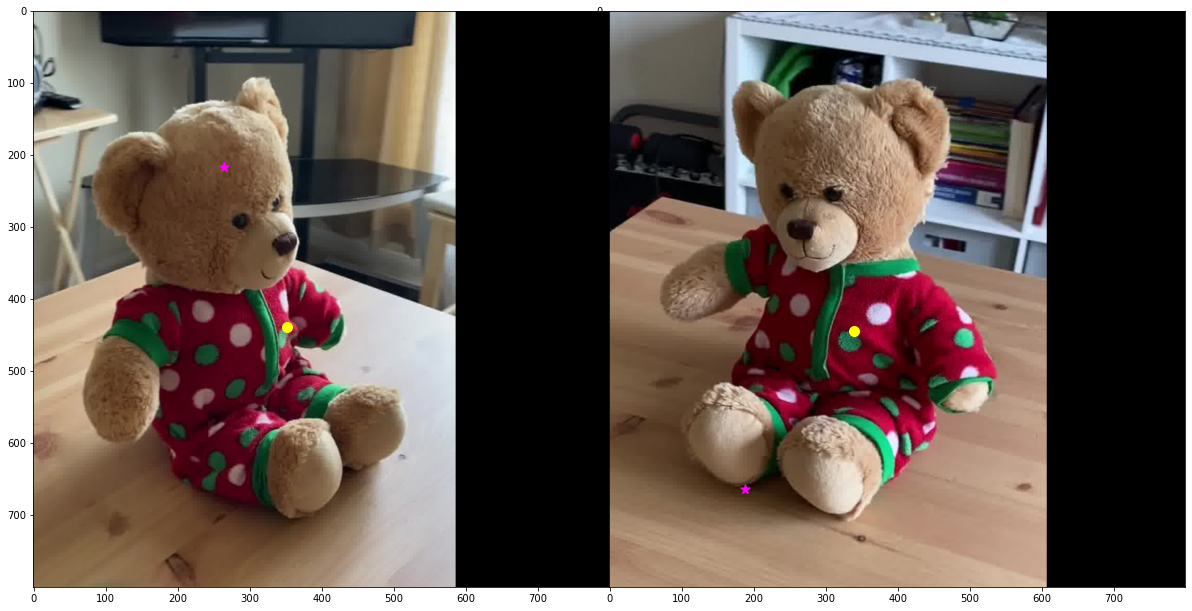

In [42]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

plt.subplot(1, 2, 1)
plt.imshow(img1.numpy())
for x, y in result[0][corr_idx:corr_idx+1]:
    x = x.item()
    y = y.item()
    plt.scatter(x, y, s=100, c="yellow")
    x = p1_in_img0[0].item()
    y = p1_in_img0[1].item()
    plt.scatter(x, y, s=100, c="magenta", marker='*')
    
plt.subplot(1, 2, 2)
plt.imshow(img2.numpy())
for x, y in result[1][corr_idx:corr_idx+1]:
    x = x.item()
    y = y.item()
    plt.scatter(x, y, s=100, c="yellow")
    x = p0_in_img1[0].item()
    y = p0_in_img1[1].item()
    plt.scatter(x, y, s=100, c="magenta", marker='*')

keypoint_left = result[0, corr_idx]
keypoint_right = result[1, corr_idx]

print(keypoint_left, keypoint_right)

In [98]:
result_one

tensor([[[175., 245.]],

        [[137., 286.]]], device='cuda:0')

In [119]:
pair_rays = get_pair_rays(pair_idxs, src_cams, H, W, result_one)

screen : tensor([[175., 245.,   1.]], device='cuda:0')
ndc : tensor([[0.5624, 0.3874, 1.0000]], device='cuda:0')
cam : tensor([[0.1157, 0.1936, 1.0000]], device='cuda:0')
world : tensor([[-0.1345,  0.6928, -8.7586]], device='cuda:0')
screen : tensor([[137., 286.,   1.]], device='cuda:0')
ndc : tensor([[0.6574, 0.2848, 1.0000]], device='cuda:0')
cam : tensor([[0.1336, 0.2024, 1.0000]], device='cuda:0')
world : tensor([[-4.8367, -0.4998, -7.0478]], device='cuda:0')


In [43]:
proj_ray_dist_loss_single(result_one[0], result_one[1], src_cams, pair_idxs, pair_rays, "train", 800, 800)

(tensor(nan, device='cuda:0'), 0.0)

In [93]:
p0

tensor([[[-1.1264, -0.9474, -0.3630]]], device='cuda:0')

In [94]:
p1

tensor([[[-1.1132, -0.9620, -0.3681]]], device='cuda:0')